<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp_tf-idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
import seaborn as sns
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# NLP libraries
import nltk
import re
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
oversample = RandomOverSampler(sampling_strategy='minority')

In [71]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [77]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [78]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['comment', 'topic']

In [79]:
df.isnull().sum()

comment    0
topic      0
dtype: int64

In [80]:
# Drop na 
df.dropna(axis=0, inplace=True)

In [82]:
df.topic.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
People                        113
Process                        69
PEOPLE                         32
Product                        13
PROCESS                         6
Name: topic, dtype: int64

In [83]:
#lower case
df['topic'] = df['topic'].str.lower()
df['topic'] = df['topic'].str.strip()
df.loc[df.topic=='not specified', 'topic'] = 'others'

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='count', ylabel='topic'>

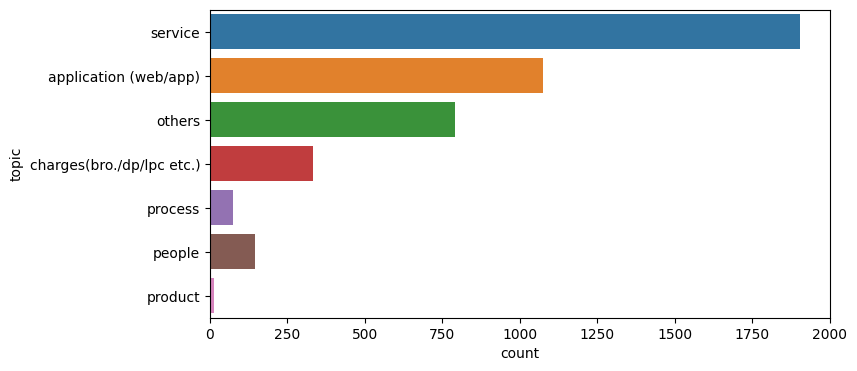

In [84]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['topic'])

In [10]:
# Preprocessing

In [86]:
# Remove integer comments
df = df[df['comment'].apply(lambda x: not isinstance(x, int))]
df.reset_index(drop=True, inplace=True)

#lower case
df['comment'] = df['comment'].str.lower()

In [87]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r"[^A-Za-z]+", ' ' , str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [88]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.remove('no')
lst_stopwords.remove('not')

In [90]:
df["x"] = df["comment"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df['y'] = df['topic']
df.head(10)

,comment,topic,x,y
0,querries where kotak is at disadvantageous pos...,service,querries kotak disadvantageous position either...,service
1,1) same-day money deduction even if we have ma...,application (web/app),day money deduction even margin position pleas...,application (web/app)
2,ndejjejdjx,others,ndejjejdjx,others
3,worst website trading,application (web/app),worst website trading,application (web/app)
4,"no technical support at real time, application...",service,no technical support real time application not...,service
5,need knowledge and experience person,service,need knowledge experience person,service
6,please revisit my brokerage and deemat charges...,charges(bro./dp/lpc etc.),please revisit brokerage deemat charge many se...,charges(bro./dp/lpc etc.)
7,iâm waiting for resolution or a meeting with...,service,waiting resolution meeting mr uday kotak card ...,service
8,i dint interacted so my rating may be a bias b...,service,dint interacted rating may bias better not con...,service
9,no issues with the rm,service,no issue rm,service


In [91]:
# Dict for classes
df['category_id'] = df['y'].factorize()[0]
category_id_df = df[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [93]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=15, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(df['x']).toarray()
labels = df.category_id
features.shape

(4335, 514)

In [94]:
pd.DataFrame(features.transpose(),index=tfidfVector.get_feature_names_out())

0     1     2     3     4     5     6     7     8     9     10    \
aap          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
able         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
absolutely   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
access       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
account      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
wrong        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
year         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
yes          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zero         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zerodha      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                11    12    13    14    15    16    17    18    19    \
aap         0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
able        0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
absolutely  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
access      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
account     0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   
wrong       0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
year        0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
yes         0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zero        0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zerodha     0.162493   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                20        21    22    23    24    25       26    27    28    \
aap         0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
able        0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
absolutely  0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
access      0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
account     0.265295  0.170817   0.0   0.0   0.0   0.0  0.23088   0.0   0.0   
...              ...       ...   ...   ...   ...   ...      ...   ...   ...   
wrong       0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
year        0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
yes         0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
zero        0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   
zerodha     0.000000  0.000000   0.0   0.0   0.0   0.0  0.00000   0.0   0.0   

                29    30    31    32    33        34    35        36    37    \
aap         0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
able        0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.309754   0.0   
absolutely  0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
access      0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
account     0.185536   0.0   0.0   0.0   0.0  0.359669   0.0  0.000000   0.0   
...              ...   ...   ...   ...   ...       ...   ...       ...   ...   
wrong       0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
year        0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
yes         0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
zero        0.289965   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   
zerodha     0.000000   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000   0.0   

            38    39    40    41    42    43    44    45    46    47    48    \
aap          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
able         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
absolutely   0.0   0.0   0.0   0.0  

In [55]:
# smt = SMOTETomek(sampling_strategy = 'auto', random_state=42)
# X, y = smt.fit_resample(features, labels)

In [56]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='auto',random_state=42,k_neighbors=2)
# X, y = sm.fit_resample(features, labels)

In [ ]:
# df_smote = pd.DataFrame(X)

In [117]:
X = features
y = labels

In [118]:
features.shape

(4335, 514)

In [119]:
# We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for i, j in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == j)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names_out())[indices]
    # print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(i))
    # print(feature_names)
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'application (web/app)':
 Most correlated unigrams:
. neo
. app
 Most correlated bigrams:
. improve app
. kotak neo
# 'charges(bro./dp/lpc etc.)':
 Most correlated unigrams:
. charge
. brokerage
 Most correlated bigrams:
. charge high
. brokerage charge
# 'others':
 Most correlated unigrams:
. ok
. good
 Most correlated bigrams:
. customer service
. customer care
# 'people':
 Most correlated unigrams:
. support
. knowledge
 Most correlated bigrams:
. care executive
. customer support
# 'process':
 Most correlated unigrams:
. transfer
. process
 Most correlated bigrams:
. solve problem
. trading account
# 'product':
 Most correlated unigrams:
. investment
. recommendation
 Most correlated bigrams:
. till date
. long time
# 'service':
 Most correlated unigrams:
. dealer
. service
 Most correlated bigrams:
. worst service
. customer service


<Axes: xlabel='model_name', ylabel='accuracy'>

<Axes: xlabel='model_name', ylabel='accuracy'>

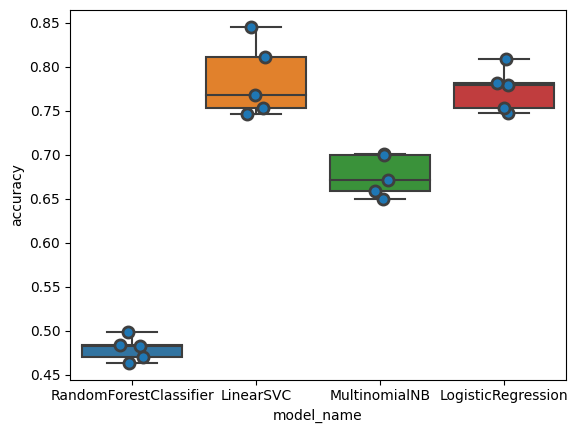

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [121]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
model = LinearSVC(class_weight = 'balanced')
# model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.33, stratify=y, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

LinearSVC(class_weight='balanced')

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

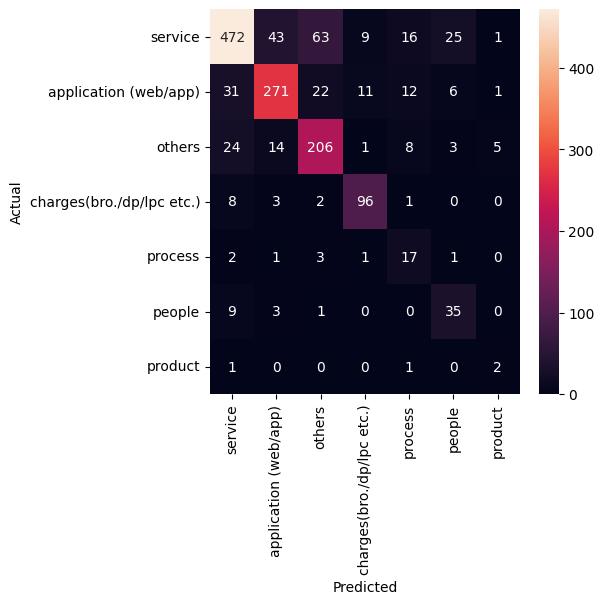

In [122]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [123]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['y'].unique()))

                           precision    recall  f1-score   support

                  service       0.86      0.75      0.80       629
    application (web/app)       0.81      0.77      0.79       354
                   others       0.69      0.79      0.74       261
charges(bro./dp/lpc etc.)       0.81      0.87      0.84       110
                  process       0.31      0.68      0.42        25
                   people       0.50      0.73      0.59        48
                  product       0.22      0.50      0.31         4

                 accuracy                           0.77      1431
                macro avg       0.60      0.73      0.64      1431
             weighted avg       0.79      0.77      0.78      1431



In [124]:
y_pred_overall = model.predict(X)

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

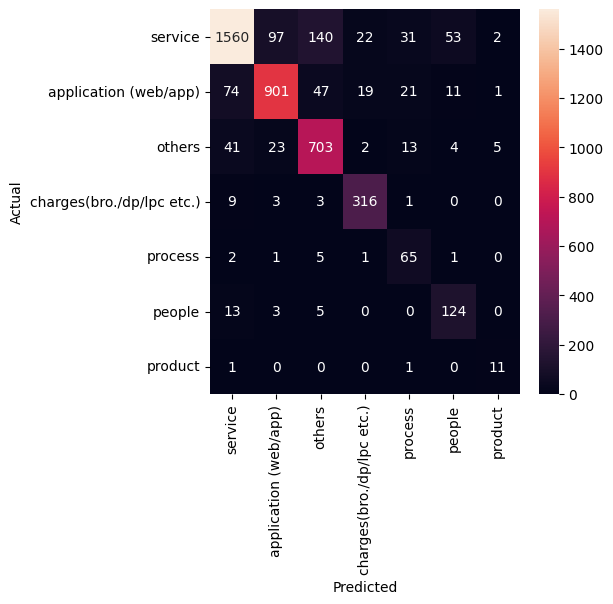

In [125]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y, y_pred_overall)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [126]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(y, y_pred_overall, target_names=df['y'].unique()))

                           precision    recall  f1-score   support

                  service       0.92      0.82      0.87      1905
    application (web/app)       0.88      0.84      0.86      1074
                   others       0.78      0.89      0.83       791
charges(bro./dp/lpc etc.)       0.88      0.95      0.91       332
                  process       0.49      0.87      0.63        75
                   people       0.64      0.86      0.73       145
                  product       0.58      0.85      0.69        13

                 accuracy                           0.85      4335
                macro avg       0.74      0.87      0.79      4335
             weighted avg       0.86      0.85      0.85      4335



In [ ]:
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 30:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['x']])
            print('')